## Create dataloader

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
from data_loader import MyDataset
from torch.utils.data import DataLoader
from models.unet import UNet, PretrainedUNet, output_maps
from utils.visualize_star import visualize
import yaml
from utils.circular_loss import CircularAELoss
from tqdm import tqdm

In [3]:
with open('config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# labels_path = config['labels_path']
# images_path = config['images_path']
labels_path = config['toy_labels_path']
images_path = config['toy_images_path']
n_rays = config['n_rays']

In [4]:
dataset = MyDataset(images_path, labels_path, n_rays)
dataset_size = len(dataset)
print(dataset_size)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

480


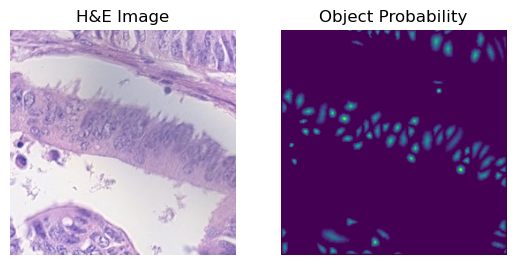

In [5]:
test_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1)
data = next(iter(test_loader))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('H&E Image')  
plt.imshow(data[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Object Probability') 
plt.imshow(data[1][0])
plt.show()


In [6]:
image, obj_prob, star_distances, star_angles = data

## visualize "star points" from data loader

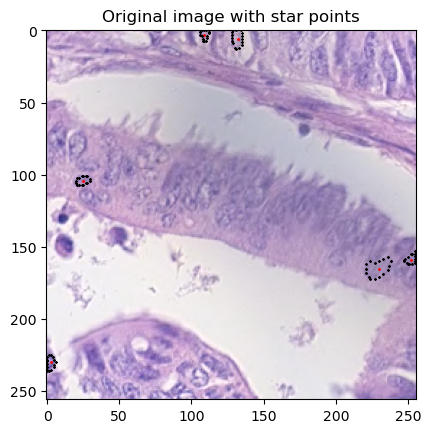

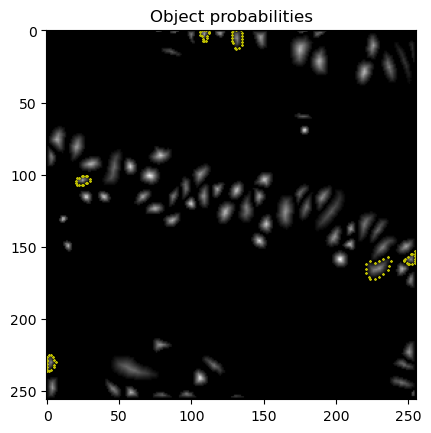

In [7]:
visualize(image[0], obj_prob[0], star_distances[0], star_angles[0])

In [8]:
print(star_distances[0].shape)
print(star_angles[0].shape)

torch.Size([256, 256, 16])
torch.Size([256, 256, 16])


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
model1 = output_maps(n_rays=n_rays).to(device)

In [11]:
#Hyperparameters taken from paper:
batch_size = config['batch_size']
lr = config['lr']
num_epochs = config['num_epochs']
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss1 = torch.nn.BCEWithLogitsLoss()
loss2 = torch.nn.MSELoss(reduction='none')
loss3 = CircularAELoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [12]:
# cuda clear cache
torch.cuda.empty_cache()


## Training loop

In [13]:
# save training loss
obj_prob_loss_epoch_train = []
dist_loss_epoch_train = []
angles_loss_epoch_train = []
total_loss_epoch_train = []
# save validation loss  
obj_prob_loss_epoch_val = []
dist_loss_epoch_val = []
angles_loss_epoch_val = []
total_loss_epoch_val = []
num_batches_train = len(train_loader)
num_batches_val = len(val_loader) 
# training loop 
for epoch in (range(num_epochs)):
    print("Epoch: {}".format(epoch))
    obj_prob_running_loss = 0.0
    dist_running_loss = 0.0
    angles_running_loss = 0.0
    total_running_loss = 0.0
    print("Train")
    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        images, object_probabilities, star_poly_dist, star_angles = data
        images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
        # pdb.set_trace()
        outputs = model(images)
        pred_prob, star = model1(outputs)
        pred_dist = star[:,:n_rays,:,:]
        pred_angles = star[:,n_rays:,:,:]
        obj_prob_loss = loss1(pred_prob.squeeze(1), object_probabilities)
        dist_loss = torch.mean(loss2(pred_dist, star_poly_dist.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
        angles_loss = torch.mean(loss3(pred_angles, star_angles.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
        loss = obj_prob_loss + dist_loss + angles_loss
        # pdb.set_trace()
        loss.backward()
        optimizer.step()
        obj_prob_running_loss += obj_prob_loss.item()
        dist_running_loss += dist_loss.item()
        angles_running_loss += angles_loss.item()
        total_running_loss += loss.item()
    obj_prob_loss_epoch_train.append(obj_prob_running_loss/num_batches_train)
    dist_loss_epoch_train.append(dist_running_loss/num_batches_train)
    angles_loss_epoch_train.append(angles_running_loss/num_batches_train)
    total_loss_epoch_train.append(total_running_loss/num_batches_train)
    print("Object Probability Loss: {}, Distance Loss: {}, Angle loss: {}, Total loss: {}".format(obj_prob_loss_epoch_train[-1], dist_loss_epoch_train[-1], angles_loss_epoch_train[-1],total_loss_epoch_train[-1]))


    model.eval()
    with torch.no_grad():
        obj_prob_running_loss = 0.0
        dist_running_loss = 0.0
        angles_running_loss = 0.0
        total_running_loss = 0.0
        print("Validation")
        for i, data in enumerate(val_loader):
            images, object_probabilities, star_poly_dist, star_angles = data
            images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
            outputs = model(images)
            pred_prob, star = model1(outputs)
            pred_dist = star[:,:n_rays,:,:]
            pred_angles = star[:,n_rays:,:,:]
            obj_prob_loss = loss1(pred_prob.squeeze(1), object_probabilities)
            dist_loss = torch.mean(loss2(pred_dist, star_poly_dist.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
            angles_loss = torch.mean(loss3(pred_angles, star_angles.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
            loss = obj_prob_loss + dist_loss + angles_loss
            obj_prob_running_loss += obj_prob_loss.item()
            dist_running_loss += dist_loss.item()
            angles_running_loss += angles_loss.item()
            total_running_loss += loss.item()
        obj_prob_loss_epoch_val.append(obj_prob_running_loss/num_batches_val)
        dist_loss_epoch_val.append(dist_running_loss/num_batches_val)
        angles_loss_epoch_val.append(angles_running_loss/num_batches_val)
        total_loss_epoch_val.append(total_running_loss/num_batches_val)
        print("Object Probability Loss: {}, Distance Loss: {}, Angle loss: {}, Total loss: {}".format(obj_prob_loss_epoch_val[-1], dist_loss_epoch_val[-1], angles_loss_epoch_val[-1],total_loss_epoch_val[-1]))

            


Epoch: 0
Train


24it [01:09,  2.91s/it]


Object Probability Loss: 1.8828429675971468, Distance Loss: 1.0532718474666278, Angle loss: 0.004559098044410348, Total loss: 2.940673922499021
Validation
Object Probability Loss: 0.10516009355584781, Distance Loss: 0.9137999812761942, Angle loss: 0.0043099746108055115, Total loss: 1.0232700407505035
Epoch: 1
Train


24it [01:31,  3.82s/it]


Object Probability Loss: 0.12612684505681196, Distance Loss: 1.0235503564278285, Angle loss: 0.004031794902402908, Total loss: 1.1537090068062146
Validation
Object Probability Loss: 0.08091512943307559, Distance Loss: 0.8625048299630483, Angle loss: 0.003310856486981114, Total loss: 0.9467308024565378
Epoch: 2
Train


24it [01:11,  2.96s/it]


Object Probability Loss: 0.08420832765599091, Distance Loss: 0.9722690631945928, Angle loss: 0.0033835482997043678, Total loss: 1.0598609273632367
Validation
Object Probability Loss: 0.07745567585031192, Distance Loss: 0.834815909465154, Angle loss: 0.0030901019539063177, Total loss: 0.9153616825739542


In [ ]:
# save model dict
torch.save(model.state_dict(), './output/weights/model.pth')
torch.save(model1.state_dict(), './output/weights/model1.pth')

## Inference

In [14]:
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1)

In [59]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, object_probabilities, star_poly_dist, star_angles = data
        images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
        outputs = model(images)
        pred_prob, star = model1(outputs)
        pred_prob = torch.sigmoid(pred_prob)
        pred_dist = star[:,:n_rays,:,:]
        pred_angles = star[:,n_rays:,:,:]
        break

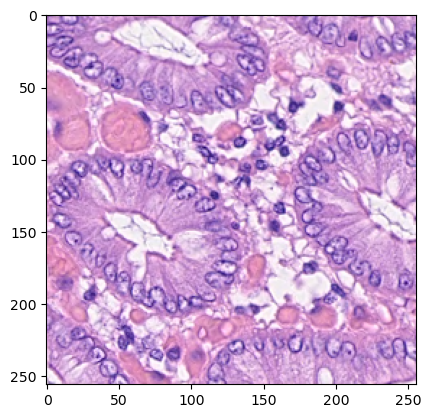

In [60]:
plt.imshow(images[0].permute(1,2,0).cpu().numpy())

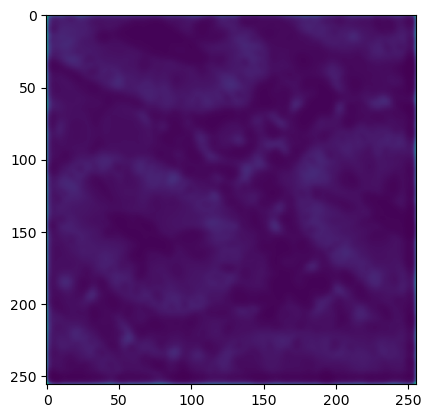

In [61]:
plt.imshow(pred_prob[0].cpu().numpy().squeeze(0))

In [62]:
pred_prob = pred_prob[0].cpu().numpy().squeeze()

In [69]:
pred_prob[:,:20] = 0
pred_prob[:,-20:] = 0
pred_prob[:20,:] = 0
pred_prob[-20:,:] = 0

> c:\users\nisch\onedrive\documents\stardist\stardist-lizard\utils\visualize_star.py(43)visualize()
     41     filtered_points = filter_points(mid_points, 5)
     42     pdb.set_trace()
---> 43     X = []
     44     Y = []
     45     for point in filtered_points:



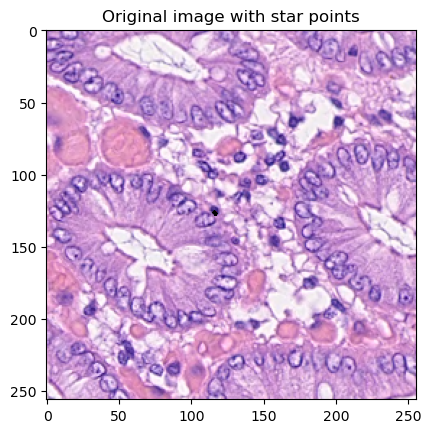

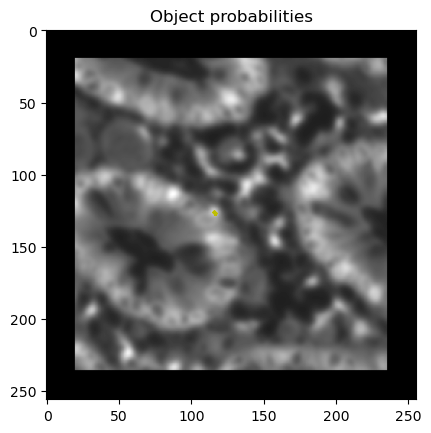

In [77]:
visualize(images[0].cpu(), pred_prob, pred_dist[0].cpu().permute(1,2,0), pred_angles[0].cpu().permute(1,2,0))

In [83]:
# pred_prob = pred_prob.cpu().numpy().squeeze()
percentile_99_5 = np.percentile(pred_prob, 99.99)
# select points where object_probabilities > percentile_99.5
mid_points = np.argwhere(pred_prob > percentile_99_5)

In [84]:
mid_points.shape

(7, 2)

In [85]:
pred_prob.shape

(256, 256)

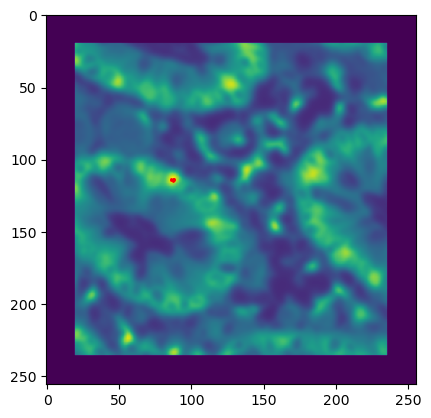

In [86]:
plt.scatter(mid_points[:,1], mid_points[:,0], s=1, c='r')
plt.imshow(pred_prob)

In [87]:
mid_points

array([[113,  86],
       [113,  87],
       [113,  88],
       [114,  86],
       [114,  87],
       [114,  88],
       [115,  87]], dtype=int64)

In [89]:
pred_angles[0].cpu().permute(1,2,0)[114,87]

tensor([9.7143e-11, 1.9365e-04, 1.5939e-03, 9.0458e-11, 1.1534e-05, 1.2929e-01,
        1.8245e-07, 4.2213e-01, 5.9163e-01, 9.9944e-01, 9.9429e-01, 1.3389e-02,
        6.6677e-01, 8.7788e-01, 5.6998e-02, 6.6905e-05])